# Prediction

DeepSensor provides a convenient high-level interface to predict directly to `xarray` or `pandas` objects
in the original units and coordinate system of your data. This is achieved using the [`model.predict` method](https://tom-andersson.github.io/deepsensor/reference/model/model.html#deepsensor.model.model.DeepSensorModel.predict).
We'll use our trained model from the [](./training.ipynb) page to demonstrate DeepSensor's prediction functionality.

The two key arguments of `model.predict` are 1) a `Task` (or list of `Task`s) containing context data, and 2) a set of target prediction locations, `X_t`.
This page will demonstrate how we can predict on-grid or off-grid based on the form of `X_t`.
We will also see how we can use optional extra arguments in `model.predict` for more advanced usage.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "usa"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
verbose_download = True

In [3]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.63it/s]


1.41 GB loaded in 7.09 s


In [4]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [5]:
set_gpu_default_device()

In [6]:
# Set up model
model = ConvNP(data_processor, task_loader, deepsensor_folder)

## Predict on-grid to xarray

If `X_t` is an `xarray` object, `model.predict` will return `xarray` predictions on the same grid as that object
(with the resolution optionally scaled by `resolution_factor`).

In [7]:
date = "2019-06-25"
test_task = task_loader(date, [100, "all", "all"], seed_override=42)
pred = model.predict(test_task, X_t=era5_raw_ds, resolution_factor=2)

The result is a single dictionary-like [`Prediction`](../reference/model/pred.rst) object
whose keys are the variable IDs of the target variables, each mapping to `xarray.Dataset` objects containing
the prediction parameters (in this case the `mean` and `std` of the `ConvNP`'s Gaussian likelihood).

In [8]:
pred["2m_temperature"]

<xarray.Dataset>
Dimensions:  (time: 1, lat: 482, lon: 802)
Coordinates:
  * lat      (lat) float64 75.0 74.88 74.75 74.63 ... 15.37 15.25 15.12 15.0
  * lon      (lon) float64 -160.0 -159.9 -159.8 -159.6 ... -60.25 -60.12 -60.0
  * time     (time) datetime64[ns] 2019-06-25
Data variables:
    mean     (time, lat, lon) float32 275.0 275.2 275.1 ... 300.9 300.9 301.1
    std      (time, lat, lon) float32 1.811 1.665 1.554 ... 0.6224 0.629 0.6557

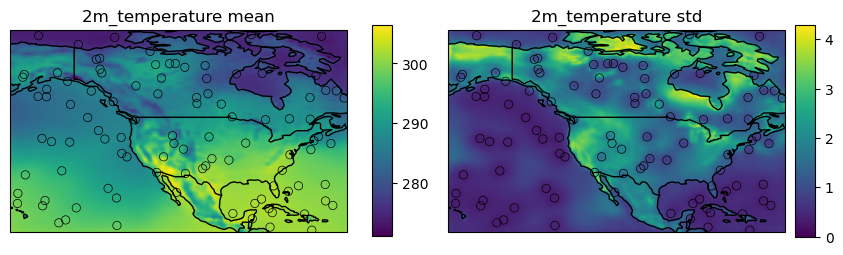

In [9]:
fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree())

## Predict off-grid to pandas

Predicting at off-grid locations with `model.predict` is very similar to the on-grid case above.
If `X_t` is 1) a shape $(2, N)$ `numpy` array, or 2) a `pandas` object containing spatial indexes, the values of the `Prediction`
returned by `model.predict` will be `pandas.DataFrame`s whose columns are the prediction parameters.

Let's see an example where we pass a *list* of `Task`s to `model.predict`, with context sets spanning the second half of 2019. Check out the indexes of the resulting `pandas.DataFrame`!

In [10]:
# Predict at two off-grid locations over six months of 2019 with 200 random context points (fixed across time)
test_tasks = task_loader(pd.date_range("2019-06-01", "2019-12-31"), [200, "all", "all"], seed_override=42)
X_t = np.array([[50, -80],
                [40, -110]]).T
pred = model.predict(test_tasks, X_t=X_t)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


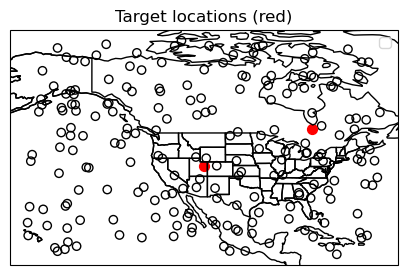

In [11]:
# plot the target locations and the context locations on a map
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.PlateCarree()})
deepsensor.plot.offgrid_context(ax, test_tasks[0], data_processor, task_loader)
ax.scatter(X_t[1], X_t[0], c="r", s=50)
ax.coastlines()
ax.set_title("Target locations (red)")
ax.add_feature(ccrs.cartopy.feature.STATES)

In [12]:
pred["2m_temperature"]

mean       std
time       lat lon                       
2019-06-01 50  -80   280.406281  1.834735
           40  -110  290.741547  2.129284
2019-06-02 50  -80   282.370087  1.753442
           40  -110  292.015839  1.990584
2019-06-03 50  -80   281.934479  1.701114
...                         ...       ...
2019-12-29 40  -110  261.715698  3.435812
2019-12-30 50  -80   263.644775  2.347633
           40  -110    261.7883   3.48374
2019-12-31 50  -80   267.722748  1.995918
           40  -110   262.06546  3.490994

[428 rows x 2 columns]

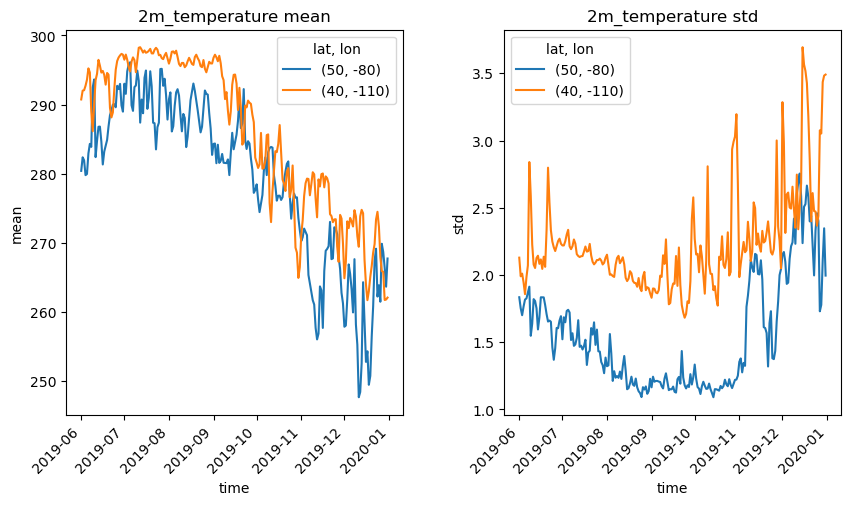

In [13]:
fig = deepsensor.plot.prediction(pred)

## Advanced: Autoregressive sampling

The `model.predict` method supports autoregressive (AR) sampling, which is useful for generating
spatially correlated samples.
AR sampling works by passing model samples at target points back into the model as context points.
In `model.predict`, this is achieved by passing `n_samples > 0` with `ar_sample`.

AR sampling can be computationally expensive because it requires a forward pass of the model for each
target point. DeepSensor provides functionality to
draw cheaper AR samples only over a subset of target points, and then interpolate those 
samples with a single forward pass of the model.
This is achieved using by passing an integer `ar_subsample_factor > 1`.
`X_t` will be subsampled by a factor of `ar_subsample_factor` in both
spatial dimensions to obtain the AR sample locations.
Note, subsampling will result in a loss of spatial granularity in the AR samples.

For more information, check out the [Autoregressive Conditional Neural Processes](https://arxiv.org/abs/2303.14468) paper (ICLR, 2023).

In [14]:
date = "2019-06-25"
test_task = task_loader(date, [100, "all", "all"], seed_override=42)
X_t = era5_raw_ds
pred = model.predict(test_task, X_t=X_t, n_samples=3, ar_sample=True, ar_subsample_factor=10)

In [15]:
pred["2m_temperature"]

<xarray.Dataset>
Dimensions:   (time: 1, lat: 241, lon: 401)
Coordinates:
  * lat       (lat) float32 75.0 74.75 74.5 74.25 74.0 ... 15.75 15.5 15.25 15.0
  * lon       (lon) float32 -160.0 -159.8 -159.5 -159.2 ... -60.5 -60.25 -60.0
  * time      (time) datetime64[ns] 2019-06-25
Data variables:
    mean      (time, lat, lon) float32 275.0 275.1 274.4 ... 301.0 300.9 301.1
    std       (time, lat, lon) float32 1.811 1.553 1.384 ... 0.6224 0.6557
    sample_0  (time, lat, lon) float32 275.8 274.9 273.8 ... 302.4 302.7 303.6
    sample_1  (time, lat, lon) float32 274.5 273.8 272.9 ... 302.5 302.8 303.7
    sample_2  (time, lat, lon) float32 276.8 275.8 274.5 ... 302.5 302.7 303.7

Let's plot the *difference* between each AR sample and the mean prediction to highlight the spatial correlations we get in the AR samples.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


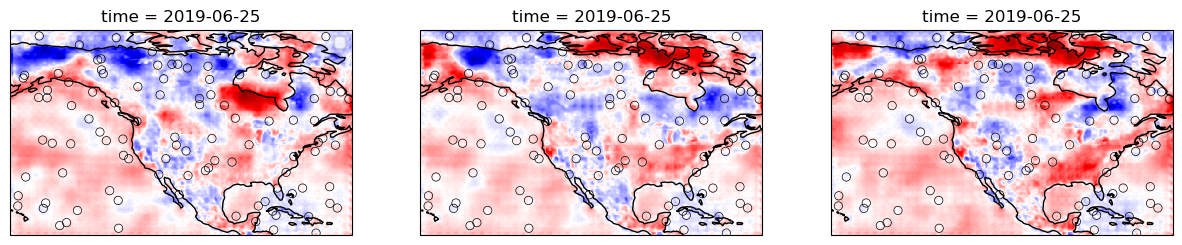

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
for sample_i, ax in enumerate(axes):
    (pred["2m_temperature"][f"sample_{sample_i}"] - pred["2m_temperature"]["mean"]).plot(ax=ax, cmap="seismic", center=0., add_colorbar=False)
    ax.coastlines()
deepsensor.plot.offgrid_context(axes, test_task, data_processor, task_loader, linewidth=0.5)
plt.show()

The checkerboard artefacts in the samples above correspond to the subsampled grid of AR sample target locations.
This could be alleviated by training the model for longer and with more examples of larger/denser context sets.